In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

# Functions for Preprocessing & Scaling Data

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# Run the code again to define and test the Min-Max scaling functions
# Define the function for Min-Max scaling
def min_max_scaling(data):
    """
    Normalize the data using Min-Max scaling.
    Args:
    - data (DataFrame): The data to normalize

    Returns:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column
    """
    scaling_params = {}
    normalized_data = data.copy()

    for column in data.columns:
        min_val = data[column].min()
        max_val = data[column].max()
        scaling_params[column] = {'min': min_val, 'max': max_val}
        normalized_data[column] = (data[column] - min_val) / (max_val - min_val)

    return normalized_data, scaling_params

# Define the function for inverse Min-Max scaling
def inverse_min_max_scaling(normalized_data, scaling_params):
    """
    Reverse the Min-Max scaling to get the original data.
    Args:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column

    Returns:
    - original_data (DataFrame): The data in its original scale
    """
    original_data = normalized_data.copy()

    for idx, column in enumerate(normalized_data.columns):
        # Convert integer column names to string to match with scaling_params keys
        key = str(column) if isinstance(column, int) else column
        keys = list(scaling_params.keys())
        min_val = scaling_params[keys[int(key)]]['min']
        max_val = scaling_params[keys[int(key)]]['max']
        original_data[column] = normalized_data[column] * (max_val - min_val) + min_val
        original_data = original_data.applymap(lambda x: max(0, x))

    return original_data

# Outlier Handling Functions

**Replace outliers for each weekday and each time slot with median for that slot and weekday**

In [ ]:
def outlier_handler(data):
    # Convert the 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Extract day of the week and time from the 'date' column
    data['day_of_week'] = data['date'].dt.day_name()
    data['time'] = data['date'].dt.time

    # Define a function to replace outliers with median for each group
    def replace_outliers(group):
        # Iterate over each column in the group
        for col in group.columns:
            if col not in ['date', 'day_of_week', 'time']:
                # Compute the IQR
                Q1 = group[col].quantile(0.25)
                Q3 = group[col].quantile(0.75)
                IQR = Q3 - Q1

                # Define bounds for outliers
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                # Replace outliers with median of the group
                median_val = group[col].median()
                group[col] = group[col].apply(lambda x: median_val if x < lower_bound or x > upper_bound else x)

        return group

    # Group by 'day_of_week' and 'time' and apply the function to replace outliers
    data = data.groupby(['day_of_week', 'time']).apply(replace_outliers)
    data = data.drop(columns=['day_of_week','time'])

    return data.reset_index().iloc[:,3:-1]

# Function for Handling Zero Points

In [ ]:
def zero_handler(data, range):
    data['date'] = pd.to_datetime(data['date'])
    data['weekday'] = data['date'].dt.dayofweek
    data['time'] = data['date'].dt.time

    # Loop over each segment column
    for col in data.columns[3:-2]:
        # Group by weekday and time slot
        grouped = data.groupby(['weekday', 'time'])

        # Define a function to apply to each group
        def replace_zeros(group):
            nonzero_mean = group[group != 0].mean()
            if pd.notnull(nonzero_mean):
                return group.replace(0, nonzero_mean)
            else:
                return group

        # Apply the function to each group in the specific segment column
        data[col] = grouped[col].transform(replace_zeros)

    data = data.drop(columns=['weekday','time'])

    return data

In [ ]:
def handle_zeros_with_rolling_mean(data, range):
    for col in data.columns[1:]:
        mv_avg = data[col].rolling(range).mean()
        for i, val in enumerate(data[col]):
            if val == 0:
                data.loc[i,col] = mv_avg[i]
    data = data.tail(-(range))
    return data

In [ ]:
import math

def fill_zeros_median(data, range_num):
    for col in data.columns[1:]:
        for i in range(range_num-1, len(data)):
            if data.loc[i,col] == 0:
                avg = data.loc[i-range_num:i+1,col].loc[data.loc[i-range_num:i+1,col] != 0 ].median()
                if math.isnan(avg):
                    avg = data.loc[i-range_num:i+range_num,col].loc[data.loc[i-range_num:i+range_num,col] != 0 ].median()
                    if math.isnan(avg):
                        # avg = data.loc[:,col].loc[data.loc[:,col] != 0 ].median()
                        avg = 0
                        # if math.isnan(avg):
                        #     avg = data1.loc[i:i+100,'3'].loc[data1.loc[i:i+100,'3'] != 0 ].mean()
                data.loc[i,col] = avg

    return data.tail(-(range_num))


# Function for Converting data into sequential data

**Get a matrix of 8 hour window as X and its next step values as Y**

In [ ]:
def formatting_features_targets(data_values, window_size, step_i,dates):
    # Preprocessing and reshaping data
    num_sequences = len(data_values) - window_size
    X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
    y = np.array([data_values[i+window_size+step_i-1] for i in range(num_sequences)])
    d = np.array([dates[i+window_size+step_i-1] for i in range(num_sequences)])
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

    return X, y,d

# Transformer Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatioTemporalModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dropout_rate=0.1):
        super(SpatioTemporalModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
#         self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
#         self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolutional layers
        self.flattened_size = (input_size[1] // 4) * (input_size[2] // 4) * 32  # Dividing by 4 due to two pooling layers
        # Bottleneck layer to adjust the dimensionality to d_model
        self.bottleneck = nn.Linear(self.flattened_size, d_model)

        # Transformer layers
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_rate
        )

        # Linear layer for prediction
        self.fc1 = nn.Linear(d_model, d_model//2)
        self.fc2 = nn.Linear(d_model//2, d_model//4)
        self.fc3 = nn.Linear(d_model//4, output_size)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flattening
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)

        # Transformer layers
        x = x.unsqueeze(0)
        x = self.transformer(x, x)
        x = x.squeeze(0)

        # Linear layer for prediction
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x

# Placing Data into Torch Tensors Functions

In [ ]:
def get_torch_tensor(df, device):
    return torch.tensor(df, dtype=torch.float32).to(device)

def get_train_val_test_loaders(X_scaled, y_scaled, val_fraction, test_fraction, device, batch_size, dates):
    test_splitter = round(len(X_scaled)*(1-test_fraction))
    X_train_val_scaled , X_test_scaled = X_scaled[:test_splitter] , X_scaled[test_splitter:]
    y_train_val_scaled , y_test_scaled = y_scaled[:test_splitter] , y_scaled[test_splitter:]
    dates_train_val_scaled , dates_test_scaled = dates[:test_splitter] , dates[test_splitter:]

    train_val_splitter = round(len(X_train_val_scaled)*(1-val_fraction))
    X_train_scaled , X_val_scaled = X_train_val_scaled[:train_val_splitter] , X_train_val_scaled[train_val_splitter:]
    y_train_scaled , y_val_scaled = y_train_val_scaled[:train_val_splitter] , y_train_val_scaled[train_val_splitter:]
    dates_train_scaled , dates_val_scaled = dates_train_val_scaled[:train_val_splitter] , dates_train_val_scaled[train_val_splitter:]

    X_train_tensor = get_torch_tensor(X_train_scaled, device)
    y_train_tensor = get_torch_tensor(y_train_scaled, device)
    X_val_tensor = get_torch_tensor(X_val_scaled, device)
    y_val_tensor = get_torch_tensor(y_val_scaled, device)
    X_test_tensor = get_torch_tensor(X_test_scaled, device)
    y_test_tensor = get_torch_tensor(y_test_scaled, device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, dates_test_scaled


# Training

In [ ]:
def training(model, train_loader, val_loader):
    # Training loop with tqdm progress bar
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs = 15
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_val_loss+=loss
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Error Metrics Functions

## For Overall

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluateModel(model, val_loader, device, scaling_params=None):
    """
    Evaluate the model and return MSE, RMSE, and MAE.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - mse (float): Mean Squared Error
    - rmse (float): Root Mean Squared Error
    - mae (float): Mean Absolute Error
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    mse = mean_squared_error(all_true_values, all_predictions)
    rmse = mean_squared_error(all_true_values, all_predictions, squared=False)
    mae = mean_absolute_error(all_true_values, all_predictions)

    return mse, rmse, mae,all_predictions,all_true_values

# Dummy code to simulate usage (We don't have the actual model and data here, so this is just for illustration)
# evaluate_model(model, val_loader, device, scaling_params)


## Errors by Segment

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Let's update the evaluate_model_per_segment function to compute MSE, RMSE, and MAE for each segment
def evaluate_model_per_segment(model, val_loader, device, scaling_params=None):
    """
    Evaluate the model for each segment and return metrics.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - segment_metrics (dict): Metrics (MSE, RMSE, MAE) for each segment
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    # Fetch predictions and true values
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    num_segments = all_predictions.shape[1]
    segment_metrics = {}

    from sklearn.metrics import mean_absolute_error
    overall_mae = mean_absolute_error(all_predictions, all_true_values)
    print(f"Overall Error Metrics ==> MAE : {overall_mae}")

    # Calculate MSE, RMSE, and MAE for each segment
    for segment_idx in range(num_segments):
        segment_predictions = all_predictions[:, segment_idx]
        segment_true_values = all_true_values[:, segment_idx]

        mse = np.mean((segment_predictions - segment_true_values)**2)
        rmse = np.sqrt(mse)
        # mae = np.mean(np.abs(segment_predictions - segment_true_values))
        mae = mean_absolute_error(segment_predictions, segment_true_values)

        segment_metrics[f"Segment {segment_idx+1}"] = {"MSE": mse, "RMSE": rmse, "MAE": mae}

    return segment_metrics

def evaluate_segments(model, test_loader, device, scaling_params=None):
    segment_metrics = evaluate_model_per_segment(model, test_loader, device, scaling_params)

    # Display metrics for each segment
    for segment, metrics in segment_metrics.items():
        print(f"{segment} => MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}")


## Visualizing Performance of Model against each segment

In [ ]:
# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Update the visualize_sorted_predictions function to reverse the normalization
def visualize_sorted_predictions(model, val_loader, device, scaling_params=None):
    """
    Visualize the sorted predictions and true values in their original scale.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    # Fetch predictions and true values
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    num_segments = all_predictions.shape[1]
    # print(inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params))

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    # Plotting each segment
    for segment_idx in range(num_segments):
        segment_predictions = all_predictions[:, segment_idx]
        segment_true_values = all_true_values[:, segment_idx]

        # Sorting the actual values and adjusting predictions accordingly
        # sorted_indices = np.argsort(segment_true_values)
        # sorted_true_values = segment_true_values[sorted_indices]
        # sorted_predictions = segment_predictions[sorted_indices]

        # sorted_indices = np.argsort(segment_true_values)
        sorted_true_values = segment_true_values
        sorted_predictions = segment_predictions

        plt.figure(figsize=(12, 6))
        plt.plot(sorted_true_values, label="Actual Values", color='blue')
        plt.plot(sorted_predictions, label="Predicted Values", color='red')
        plt.title(f"Segment {segment_idx+1}")
        plt.xlabel("Sequence Index")
        plt.ylabel("Value")
        plt.legend()
        plt.show()


# Obtainig GPU CUDA

In [ ]:
# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading the Data

In [ ]:
# timestep used for data
minutes = 5

In [ ]:
# Load the dataset
# orig_df = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/datasets/avg_run_{minutes}min_dir1.csv')

orig_df = pd.read_csv(f'/content/drive/MyDrive/Semester 5 DSE Project/Data/avg_dwell_{minutes}min_dir1v2.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Project Datasets/avg_run_{minutes}min_dir1.csv')

# orig_df = orig_df.drop(columns=['temp','precip','windspeed'])

In [53]:
orig_df = orig_df.drop(columns=['temp','precip','windspeed'])

In [ ]:
orig_df.loc[len(orig_df)-1]

date         2022-09-30 18:55:00
101.0                        0.0
102.0                        0.0
103.0                        0.0
104.0                        0.0
105.0                        0.0
106.0                        0.0
107.0                        0.0
108.0                        0.0
109.0                        0.0
110.0                        0.0
111.0                        0.0
112.0                        0.0
113.0                        0.0
114.0                        0.0
temp                        21.4
precip                       0.0
windspeed                   11.5
Name: 37439, dtype: object

# Applying the ML Process

In [54]:
zero_handle_range = int((15/minutes)*6)
data2 = orig_df
# data2 = outlier_handler(orig_df)
data2 = zero_handler(data2, zero_handle_range)
timeslots = data2['date'].values
data2 = data2.drop(columns=['date'])

data2, scaling_params2 = min_max_scaling(data2)
data_values2 = data2.values

window_size = int(8/(minutes/60))
step_i = 1
X2, y2, times = formatting_features_targets(data_values2, window_size, step_i,timeslots)

In [55]:
d_model = 512
batchSize = 64
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2

In [56]:
# Initialize the model
model2 = SpatioTemporalModel(input_size=X2.shape[1:], output_size=y2.shape[1], d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [57]:
train_loader2, val_loader2, test_loader2, dates_test = get_train_val_test_loaders(X2, y2, 0.02, 0.13, device, batchSize, times)

In [58]:
model2.to(device)
training(model2, train_loader2, val_loader2)

Epoch 1 Validation: 100%|██████████| 11/11 [00:00<00:00, 103.55it/s]


Epoch [1/15] => Train Loss: 0.0052, Val Loss: 0.0012


Epoch 2 Validation: 100%|██████████| 11/11 [00:00<00:00, 197.23it/s]


Epoch [2/15] => Train Loss: 0.0033, Val Loss: 0.0010


Epoch 3 Validation: 100%|██████████| 11/11 [00:00<00:00, 185.77it/s]


Epoch [3/15] => Train Loss: 0.0029, Val Loss: 0.0009


Epoch 4 Validation: 100%|██████████| 11/11 [00:00<00:00, 190.74it/s]


Epoch [4/15] => Train Loss: 0.0026, Val Loss: 0.0008


Epoch 5 Validation: 100%|██████████| 11/11 [00:00<00:00, 143.00it/s]


Epoch [5/15] => Train Loss: 0.0024, Val Loss: 0.0008


Epoch 6 Validation: 100%|██████████| 11/11 [00:00<00:00, 169.79it/s]


Epoch [6/15] => Train Loss: 0.0023, Val Loss: 0.0008


Epoch 7 Validation: 100%|██████████| 11/11 [00:00<00:00, 206.32it/s]


Epoch [7/15] => Train Loss: 0.0022, Val Loss: 0.0008


Epoch 8 Validation: 100%|██████████| 11/11 [00:00<00:00, 181.97it/s]


Epoch [8/15] => Train Loss: 0.0021, Val Loss: 0.0007


Epoch 9 Validation: 100%|██████████| 11/11 [00:00<00:00, 180.18it/s]


Epoch [9/15] => Train Loss: 0.0020, Val Loss: 0.0007


Epoch 10 Validation: 100%|██████████| 11/11 [00:00<00:00, 116.12it/s]


Epoch [10/15] => Train Loss: 0.0019, Val Loss: 0.0006


Epoch 11 Validation: 100%|██████████| 11/11 [00:00<00:00, 206.65it/s]


Epoch [11/15] => Train Loss: 0.0018, Val Loss: 0.0006


Epoch 12 Validation: 100%|██████████| 11/11 [00:00<00:00, 172.14it/s]


Epoch [12/15] => Train Loss: 0.0017, Val Loss: 0.0006


Epoch 13 Validation: 100%|██████████| 11/11 [00:00<00:00, 193.30it/s]


Epoch [13/15] => Train Loss: 0.0016, Val Loss: 0.0006


Epoch 14 Validation: 100%|██████████| 11/11 [00:00<00:00, 196.15it/s]


Epoch [14/15] => Train Loss: 0.0016, Val Loss: 0.0006


Epoch 15 Validation: 100%|██████████| 11/11 [00:00<00:00, 136.05it/s]

Epoch [15/15] => Train Loss: 0.0015, Val Loss: 0.0006


In [59]:
mse2, rmse2, mae2, pred, trueVal = evaluateModel(model2, test_loader2, device, scaling_params2)
print(f"MSE: {mse2:.4f}, RMSE: {rmse2:.4f}, MAE: {mae2:.4f}")
# v1 - MSE: 1747.1942, RMSE: 33.6750, MAE: 25.9307
# v3 - MSE: 1448.6693, RMSE: 31.2468, MAE: 23.5870
# v4 - MSE: 2346.4839, RMSE: 37.4656, MAE: 30.4317 batch size = 1

# 10 min - MSE: 404.0626, RMSE: 16.7137, MAE: 10.1751
# 5  min - MSE: 107.9190, RMSE: 8.8442, MAE: 2.0576
# 15 min - MSE: 478.6729, RMSE: 18.7366, MAE: 12.1529

# with zerohandler
#  5 min - MSE: 165.3000, RMSE: 11.0085, MAE: 5.8335

MSE: 498.1638, RMSE: 18.2986, MAE: 11.1596


In [60]:
evaluate_segments(model2, test_loader2, device, scaling_params2)


Overall Error Metrics ==> MAE : 11.159587582265548
Segment 1 => MSE: 926.0029, RMSE: 30.4303, MAE: 18.1254
Segment 2 => MSE: 494.6964, RMSE: 22.2418, MAE: 8.9704
Segment 3 => MSE: 92.5040, RMSE: 9.6179, MAE: 6.9206
Segment 4 => MSE: 96.8461, RMSE: 9.8410, MAE: 6.7922
Segment 5 => MSE: 2707.4486, RMSE: 52.0331, MAE: 33.8755
Segment 6 => MSE: 281.1340, RMSE: 16.7671, MAE: 11.7094
Segment 7 => MSE: 88.3511, RMSE: 9.3995, MAE: 6.0095
Segment 8 => MSE: 22.0781, RMSE: 4.6987, MAE: 3.4382
Segment 9 => MSE: 1115.2504, RMSE: 33.3954, MAE: 22.1394
Segment 10 => MSE: 226.3056, RMSE: 15.0435, MAE: 9.5874
Segment 11 => MSE: 69.5964, RMSE: 8.3424, MAE: 5.3573
Segment 12 => MSE: 59.4718, RMSE: 7.7118, MAE: 4.4793
Segment 13 => MSE: 684.4484, RMSE: 26.1620, MAE: 13.0068
Segment 14 => MSE: 110.1588, RMSE: 10.4957, MAE: 5.8227


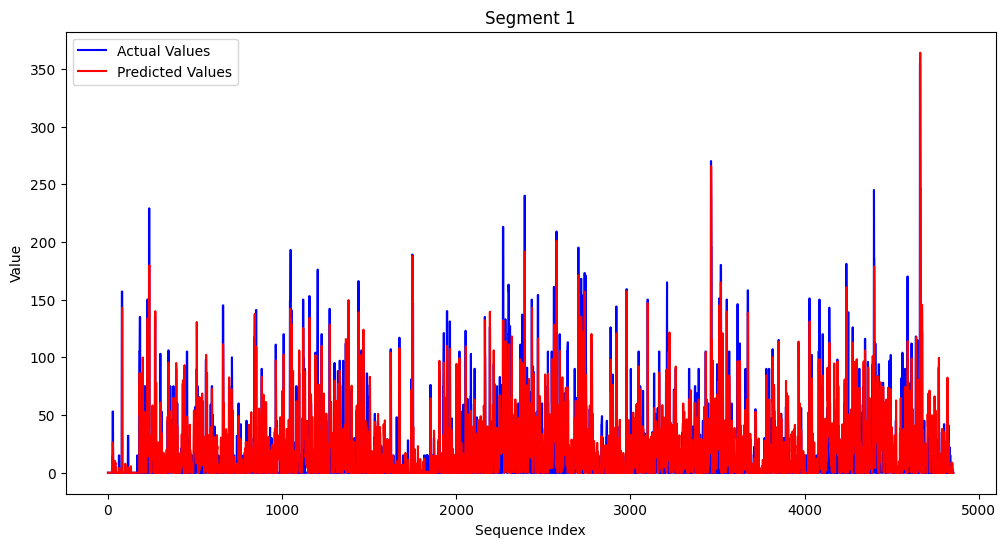

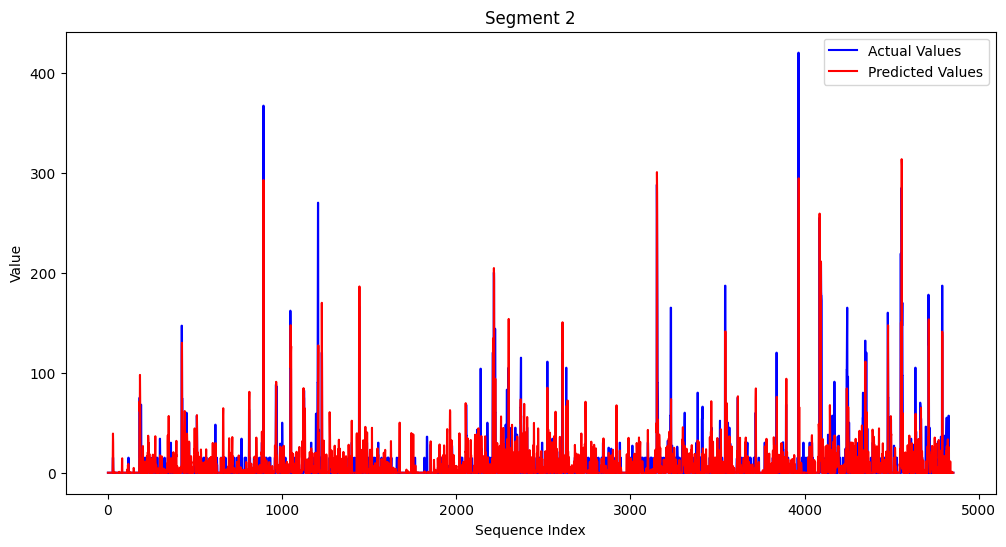

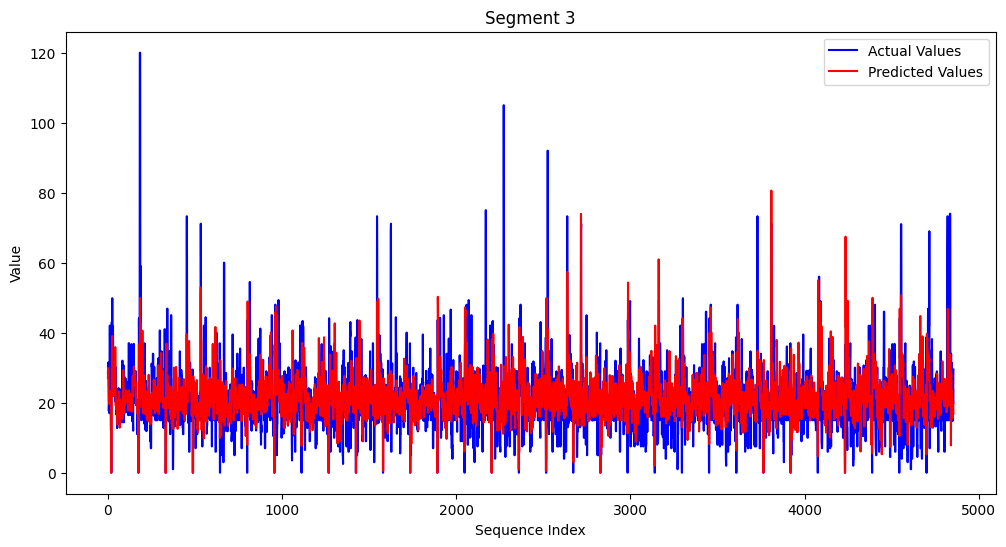

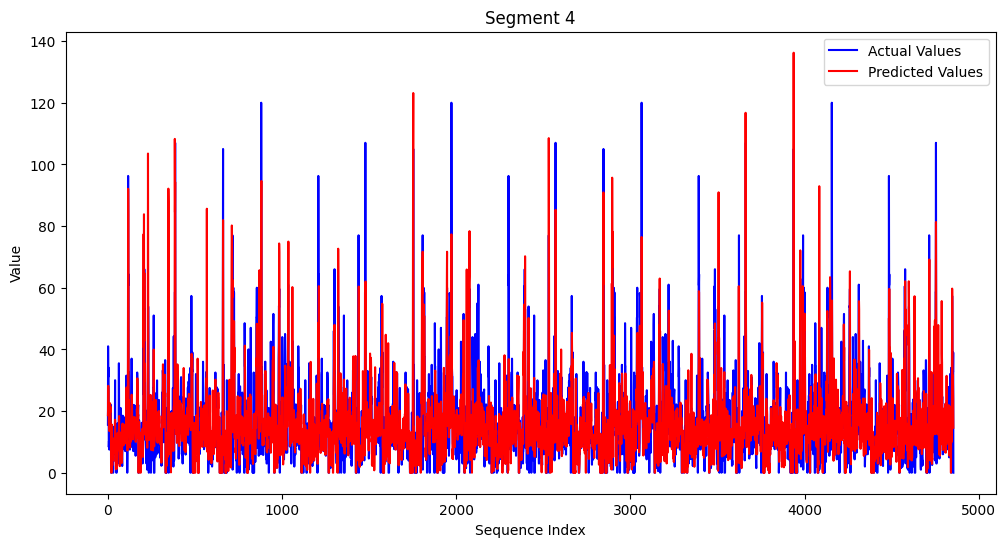

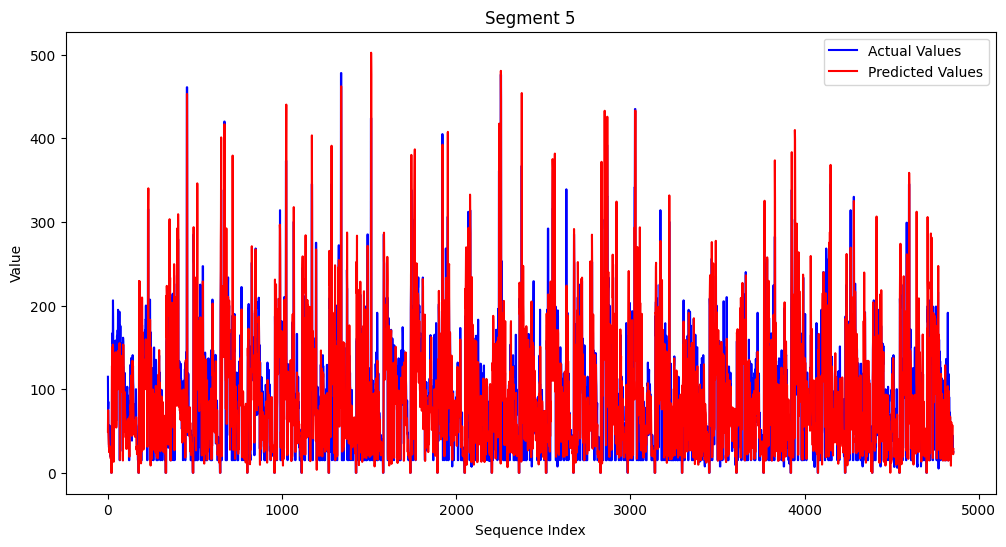

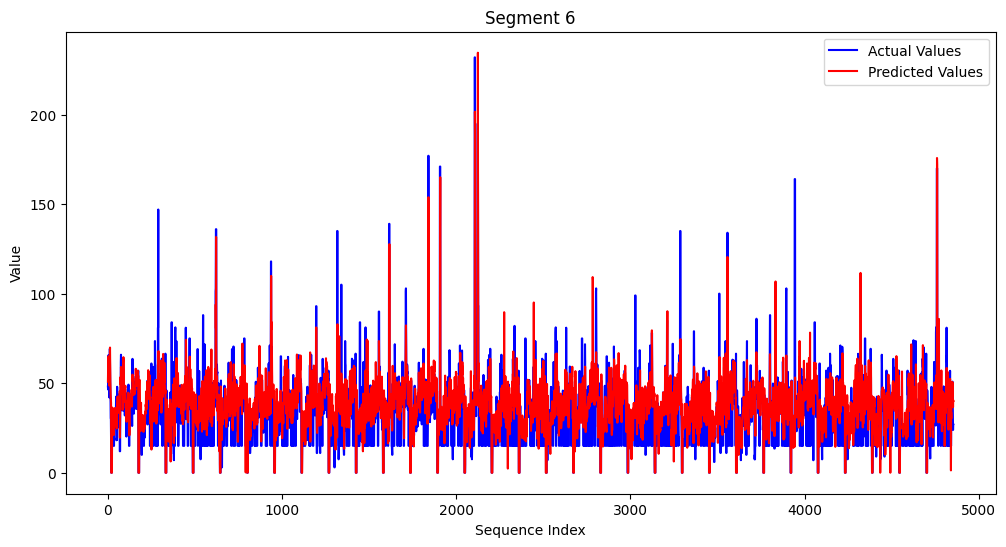

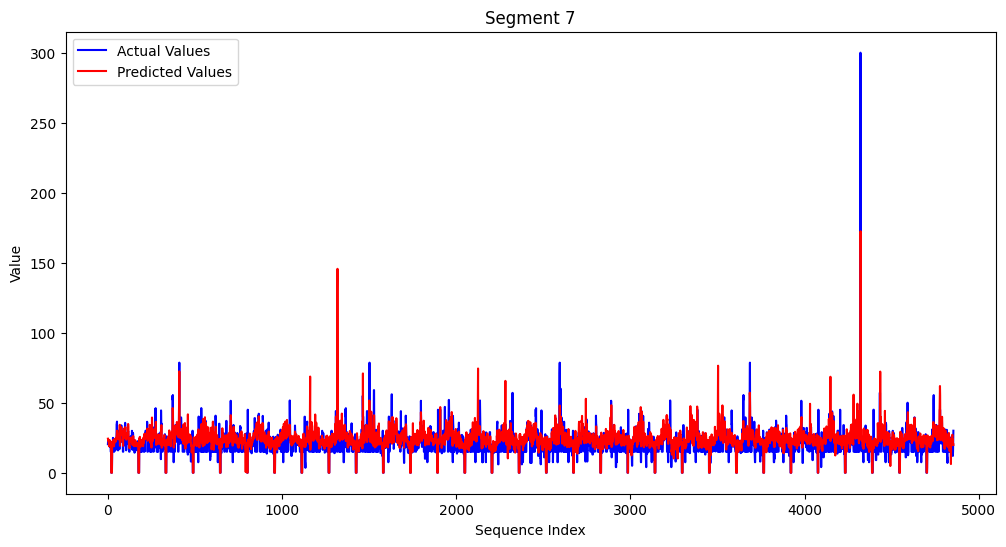

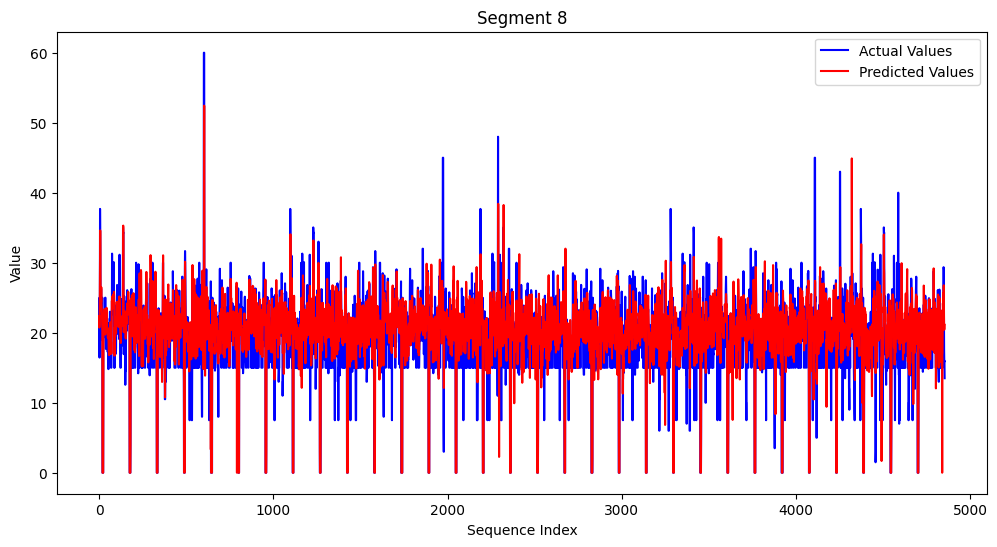

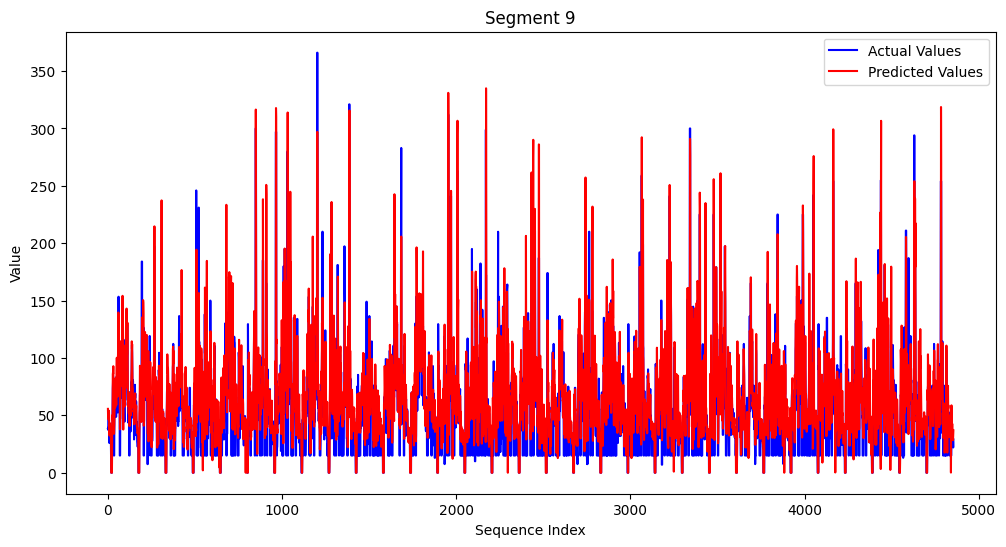

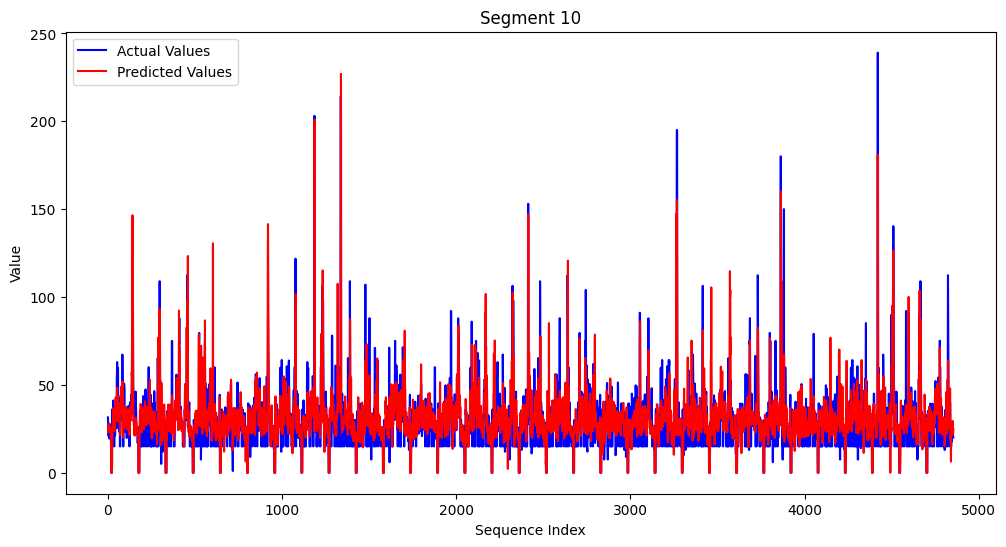

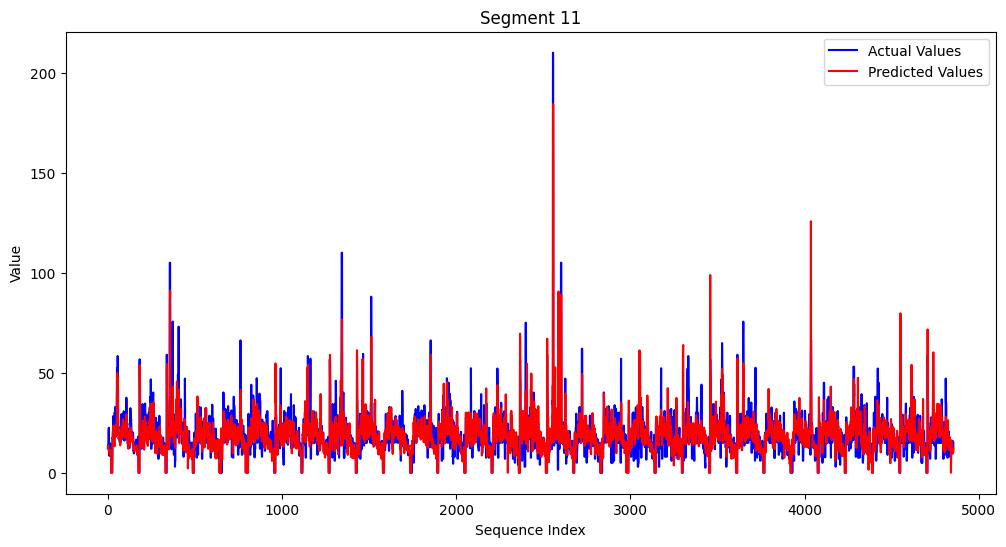

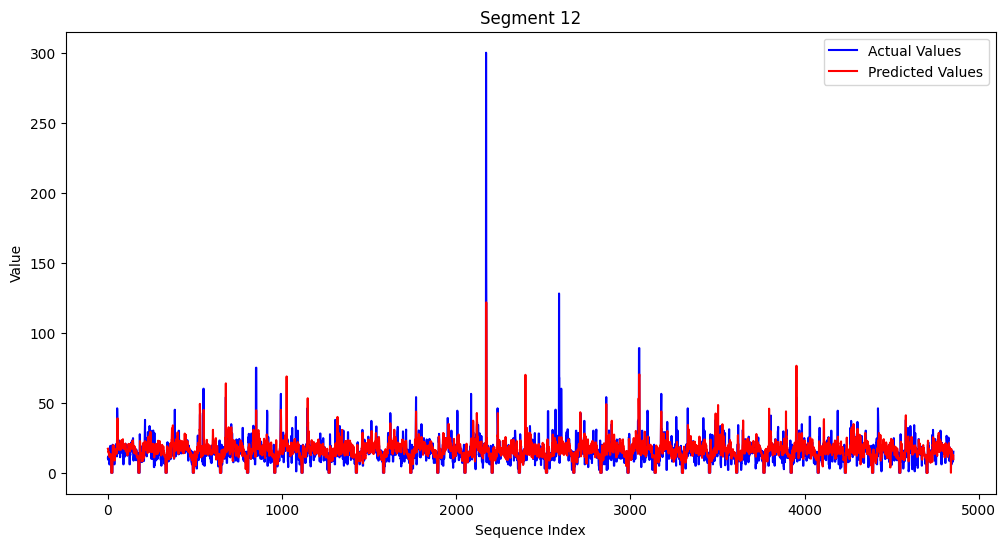

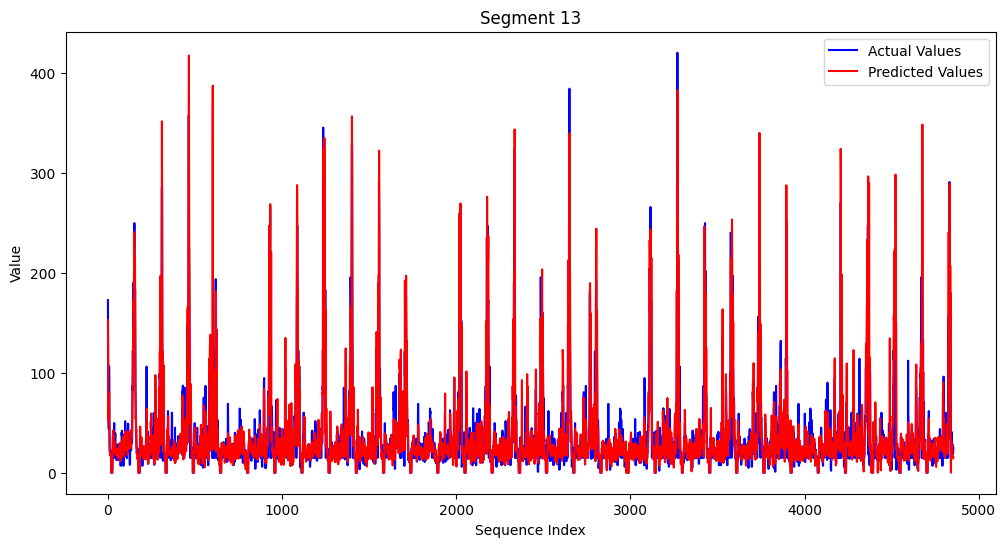

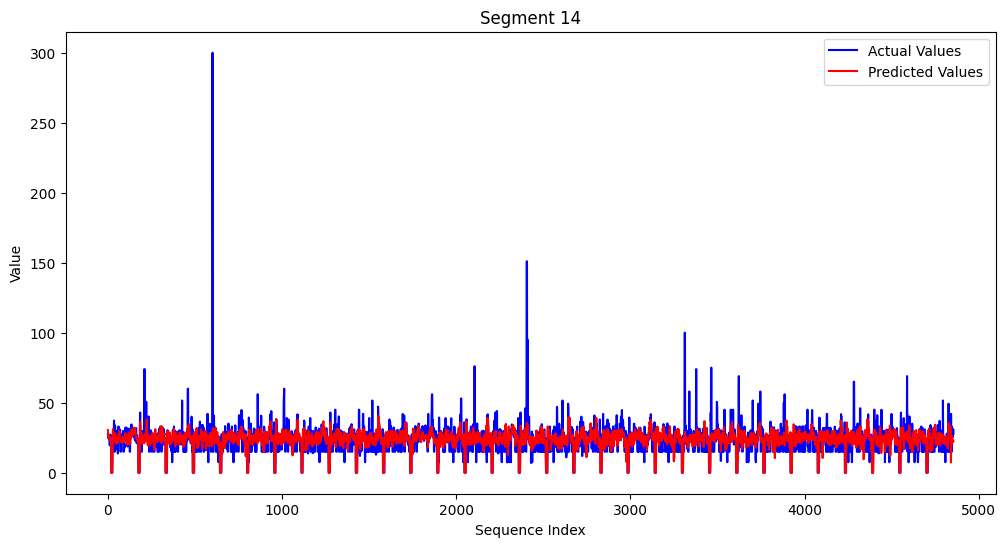

In [61]:
visualize_sorted_predictions(model2, test_loader2, device, scaling_params2)

In [62]:
r = 5

In [63]:
pred[r]

array([ 0.        ,  0.        , 21.13855553, 15.77476215, 33.80089188,
       56.03841782, 20.76891899, 30.50019073, 49.94600296, 26.71581841,
       10.78020477, 13.65924263, 62.05765533, 26.47810555])

In [64]:
trueVal[r]

array([ 0.        ,  0.        , 17.72727203,  8.33333302, 47.        ,
       51.71428299, 22.625     , 37.6875    , 51.54545212, 20.45454407,
       22.5       , 11.11111164, 43.54545593, 24.35000038])

In [65]:
dates_test[r]

numpy.datetime64('2022-08-30T17:50:00.000000000')

In [66]:
# Creating the DataFrame
column_names = ['DateTime'] + [f'{idx+1}' for idx in range(len(pred[0]))]
data = []

for date, pred_values in zip(dates_test, pred):
    row = [date] + pred_values.tolist()
    data.append(row)

df_combined = pd.DataFrame(data, columns=column_names)

df_combined

,DateTime,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2022-08-30 17:25:00,0.000000,0.0,27.081282,18.683659,49.152901,50.814850,24.321676,22.368526,55.650925,26.583277,12.153666,17.197462,152.416473,30.485966
1,2022-08-30 17:30:00,0.000000,0.0,29.916908,20.594101,74.751686,57.569206,23.872038,20.738512,49.236038,23.057728,13.655153,17.310038,126.071114,30.143997
2,2022-08-30 17:35:00,0.000000,0.0,29.691103,28.182814,51.948349,57.907196,23.189232,21.104757,49.104256,23.972784,12.992088,15.371048,68.294395,26.963783
3,2022-08-30 17:40:00,0.000000,0.0,29.047028,26.058701,44.813251,64.991722,22.648338,22.219501,46.978409,24.663044,12.618091,14.725031,51.534988,26.122334
4,2022-08-30 17:45:00,0.000000,0.0,25.473856,18.679598,40.933361,64.595512,23.649137,25.410368,46.141171,25.696959,12.190144,14.996147,64.353691,24.821966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4850,2022-09-30 18:35:00,2.894177,0.0,17.674549,21.542049,27.865696,43.119759,24.095297,23.383169,34.630535,28.799482,9.531773,12.097121,14.687626,21.953314
4851,2022-09-30 18:40:00,0.000000,0.0,19.013830,31.516472,24.563093,42.773411,19.931093,20.825186,29.857796,22.402420,10.276906,11.989171,14.250814,22.283987
4852,2022-09-30 18:45:00,0.000000,0.0,20.273441,28.444431,24.972128,36.579784,20.047659,20.432238,28.370949,21.879843,11.429659,12.300109,15.427366,22.191795
4853,2022-09-30 18:50:00,0.000000,0.0,20.288967,23.779709,22.155840,40.565941,20.933613,20.649944,32.478291,22.768967,12.192003,12.604410,15.920286,23.057730


In [67]:
initial = pd.read_csv("/content/drive/MyDrive/Semester 5 DSE Project/Data/bus_stop_times_feature_added_all.csv")

In [68]:
initial.columns

Index(['trip_id', 'deviceid', 'direction', 'bus_stop', 'date', 'arrival_time',
       'departure_time', 'dwell_time', 'dwell_time_in_seconds_old',
       'day_of_week', 'time_of_day', 'Sunday/holiday', 'saturday',
       'weekday/end', 'week_no', 'dt(w-1)', 'dt(w-2)', 'dt(w-3)', 'dt(t-1)',
       'dt(t-2)', 'dt(n-1)', 'dt(n-2)', 'dt(n-3)', 'hour_of_day', 'day',
       'month', 'temp', 'precip', 'windspeed', 'conditions', 'rt(n-1)',
       'stop_type', 'dwell_time_in_seconds'],
      dtype='object')

In [69]:
busses_new = initial[['trip_id','deviceid','direction','bus_stop','date','arrival_time','departure_time','dwell_time','dwell_time_in_seconds']]

In [70]:
busses_new.dropna(inplace=True)

<ipython-input-70-1dc632e7d6d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  busses_new.dropna(inplace=True)


In [71]:
segments = 14
time_step = 5
previous_steps = 15
pred_steps = 1
min = 1
lag = 0
start_time = '06:00:00'
end_time = '19:00:00'

In [72]:
mask = busses_new['bus_stop'] <= segments + 100

In [73]:
busses_new = busses_new[mask]

In [74]:
# Extract only the time from 'end_time' column
busses_new['arrival_time_only'] = pd.to_datetime(busses_new['arrival_time']).dt.time

# Combine 'date' and the extracted time to create 'start_datetime'
busses_new['arrival_datetime'] = pd.to_datetime(busses_new['date'] + ' ' + busses_new['arrival_time_only'].astype(str))

# Display the first few rows to verify
busses_new[['date', 'arrival_time_only', 'arrival_datetime']].head()


,date,arrival_time_only,arrival_datetime
0,2021-10-01,06:40:58,2021-10-01 06:40:58
1,2021-10-01,06:45:42,2021-10-01 06:45:42
2,2021-10-01,06:53:58,2021-10-01 06:53:58
3,2021-10-01,06:57:19,2021-10-01 06:57:19
4,2021-10-01,06:58:56,2021-10-01 06:58:56


In [75]:
busses_new.head()

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds,arrival_time_only,arrival_datetime
0,1,262,1,101,2021-10-01,06:40:58,06:42:12,0:01:14,74.0,06:40:58,2021-10-01 06:40:58
1,1,262,1,102,2021-10-01,06:45:42,06:45:42,0:00:00,0.0,06:45:42,2021-10-01 06:45:42
2,1,262,1,103,2021-10-01,06:53:58,06:54:04,0:00:06,6.0,06:53:58,2021-10-01 06:53:58
3,1,262,1,104,2021-10-01,06:57:19,06:57:19,0:00:00,0.0,06:57:19,2021-10-01 06:57:19
4,1,262,1,105,2021-10-01,06:58:56,07:02:27,0:03:31,211.0,06:58:56,2021-10-01 06:58:56


In [77]:
# Loop through each row in busses_new
for index, row in busses_new.iterrows():
    # Get the end_datetime and segment values
    arrival_dt = row['arrival_datetime']
    bus_stop = int(row['bus_stop'])

    # Find the row in df_combined where start_datetime falls in the specified range
    mask = (df_combined['DateTime'] <= arrival_dt) & (df_combined['DateTime'] + pd.Timedelta(minutes=5) > arrival_dt)

    # If there's a matching row in df_combined
    if df_combined[mask].shape[0] > 0:
        # Get the predicted value using the segment number
        predicted_value = df_combined[mask].iloc[0][bus_stop-100]

        # Assign the predicted value to the predicted_runTime column in busses_new
        busses_new.at[index, 'predicted_dwellTime'] = predicted_value
    else:
        busses_new.at[index, 'predicted_dwellTime'] = None

In [78]:
busses_new.dropna(inplace=True)

In [79]:
busses_new

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds,arrival_time_only,arrival_datetime,predicted_dwellTime
67967,21682,117,1,101,2022-08-31,06:51:45,06:52:38,0:00:53,53.0,06:51:45,2022-08-31 06:51:45,22.988306
67968,21682,117,1,102,2022-08-31,06:58:03,06:58:18,0:00:15,15.0,06:58:03,2022-08-31 06:58:03,29.797142
67969,21682,117,1,103,2022-08-31,07:10:35,07:11:04,0:00:29,29.0,07:10:35,2022-08-31 07:10:35,25.557131
67970,21682,117,1,104,2022-08-31,07:14:34,07:14:34,0:00:00,0.0,07:14:34,2022-08-31 07:14:34,10.539926
67971,21682,117,1,105,2022-08-31,07:16:26,07:16:41,0:00:15,15.0,07:16:26,2022-08-31 07:16:26,16.026163
...,...,...,...,...,...,...,...,...,...,...,...,...
78696,23383,274,1,110,2022-09-30,17:59:08,17:59:23,0:00:15,15.0,17:59:08,2022-09-30 17:59:08,19.054094
78697,23383,274,1,111,2022-09-30,18:01:57,18:02:12,0:00:15,15.0,18:01:57,2022-09-30 18:01:57,15.879804
78698,23383,274,1,112,2022-09-30,18:04:58,18:05:04,0:00:06,6.0,18:04:58,2022-09-30 18:04:58,14.478688
78699,23383,274,1,113,2022-09-30,18:07:42,18:07:57,0:00:15,15.0,18:07:42,2022-09-30 18:07:42,21.107246


In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = busses_new['dwell_time_in_seconds']
predicted_values = busses_new['predicted_dwellTime']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 15.662039377068078
MSE: 637.9752819838392
RMSE: 25.25817257807538


In [ ]:
busses_new.to_csv('/content/drive/MyDrive/Semester 5 DSE Project/Data/finalPredDwell.csv', index=False)

In [81]:
busses_new

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds,arrival_time_only,arrival_datetime,predicted_dwellTime
67967,21682,117,1,101,2022-08-31,06:51:45,06:52:38,0:00:53,53.0,06:51:45,2022-08-31 06:51:45,22.988306
67968,21682,117,1,102,2022-08-31,06:58:03,06:58:18,0:00:15,15.0,06:58:03,2022-08-31 06:58:03,29.797142
67969,21682,117,1,103,2022-08-31,07:10:35,07:11:04,0:00:29,29.0,07:10:35,2022-08-31 07:10:35,25.557131
67970,21682,117,1,104,2022-08-31,07:14:34,07:14:34,0:00:00,0.0,07:14:34,2022-08-31 07:14:34,10.539926
67971,21682,117,1,105,2022-08-31,07:16:26,07:16:41,0:00:15,15.0,07:16:26,2022-08-31 07:16:26,16.026163
...,...,...,...,...,...,...,...,...,...,...,...,...
78696,23383,274,1,110,2022-09-30,17:59:08,17:59:23,0:00:15,15.0,17:59:08,2022-09-30 17:59:08,19.054094
78697,23383,274,1,111,2022-09-30,18:01:57,18:02:12,0:00:15,15.0,18:01:57,2022-09-30 18:01:57,15.879804
78698,23383,274,1,112,2022-09-30,18:04:58,18:05:04,0:00:06,6.0,18:04:58,2022-09-30 18:04:58,14.478688
78699,23383,274,1,113,2022-09-30,18:07:42,18:07:57,0:00:15,15.0,18:07:42,2022-09-30 18:07:42,21.107246


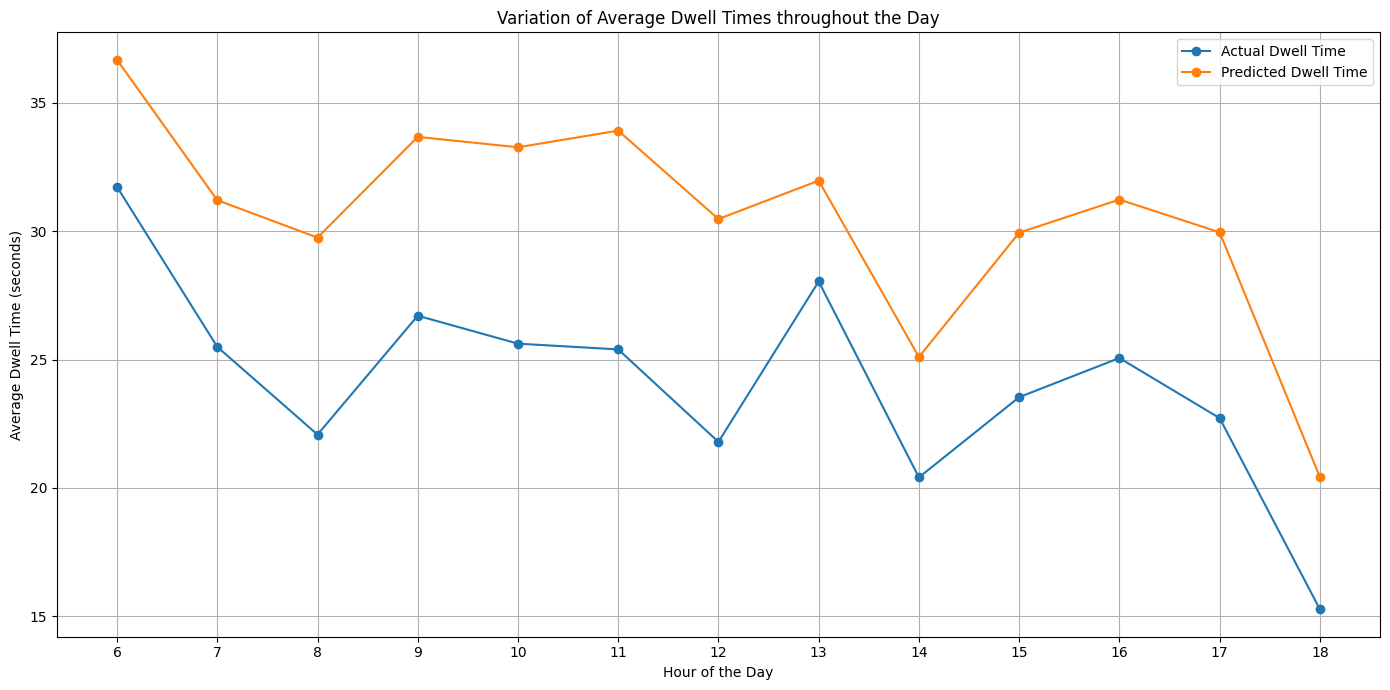

In [82]:
import matplotlib.pyplot as plt

data = busses_new
# Extract hour from the start_time column
data['hour'] = pd.to_datetime(data['arrival_time']).dt.hour

# Group by hour and calculate the average for both actual and predicted run times
grouped_data = data.groupby('hour').agg({
    'dwell_time_in_seconds': 'mean',
    'predicted_dwellTime': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(grouped_data['hour'], grouped_data['dwell_time_in_seconds'], label='Actual Dwell Time', marker='o')
plt.plot(grouped_data['hour'], grouped_data['predicted_dwellTime'], label='Predicted Dwell Time', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Dwell Time (seconds)')
plt.title('Variation of Average Dwell Times throughout the Day')
plt.legend()
plt.grid(True)
plt.xticks(grouped_data['hour'])
plt.tight_layout()
plt.show()


In [ ]:
initial.columns

In [83]:
ds = initial.copy()
ds.dropna(inplace=True)
mask = ds['bus_stop'] <= segments - 100
ds.head()

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds_old,day_of_week,...,hour_of_day,day,month,temp,precip,windspeed,conditions,rt(n-1),stop_type,dwell_time_in_seconds
0,1,262,1,101,2021-10-01,06:40:58,06:42:12,0:01:14,74.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,69.0,pro,74.0
1,1,262,1,102,2021-10-01,06:45:42,06:45:42,0:00:00,0.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,210.0,mod,0.0
2,1,262,1,103,2021-10-01,06:53:58,06:54:04,0:00:06,6.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,496.0,mod,6.0
3,1,262,1,104,2021-10-01,06:57:19,06:57:19,0:00:00,0.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,195.0,br,0.0
4,1,262,1,105,2021-10-01,06:58:56,07:02:27,0:03:31,211.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,97.0,pro,211.0


In [85]:
initial.columns

Index(['trip_id', 'deviceid', 'direction', 'bus_stop', 'date', 'arrival_time',
       'departure_time', 'dwell_time', 'dwell_time_in_seconds_old',
       'day_of_week', 'time_of_day', 'Sunday/holiday', 'saturday',
       'weekday/end', 'week_no', 'dt(w-1)', 'dt(w-2)', 'dt(w-3)', 'dt(t-1)',
       'dt(t-2)', 'dt(n-1)', 'dt(n-2)', 'dt(n-3)', 'hour_of_day', 'day',
       'month', 'temp', 'precip', 'windspeed', 'conditions', 'rt(n-1)',
       'stop_type', 'dwell_time_in_seconds'],
      dtype='object')

In [86]:
X_data = ds[['trip_id', 'deviceid', 'bus_stop', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'dt(w-1)', 'dt(w-2)', 'dt(w-3)', 'dt(t-1)', 'dt(t-2)', 'dt(n-1)',
       'dt(n-2)', 'dt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'conditions', 'rt(n-1)']]
y_data = ds['dwell_time_in_seconds']

In [87]:
X_data.head()

,trip_id,deviceid,bus_stop,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,dt(w-1),...,dt(n-2),dt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,rt(n-1)
0,1,262,101,4,6.50,0,0,1,1,92.0,...,92.0,92.0,6,1,10,20.0,0.0,6.1,Partially cloudy,69.0
1,1,262,102,4,6.75,0,0,1,1,45.0,...,45.0,45.0,6,1,10,20.0,0.0,6.1,Partially cloudy,210.0
2,1,262,103,4,6.75,0,0,1,1,28.0,...,74.0,28.0,6,1,10,20.0,0.0,6.1,Partially cloudy,496.0
3,1,262,104,4,6.75,0,0,1,1,1.0,...,0.0,74.0,6,1,10,20.0,0.0,6.1,Partially cloudy,195.0
4,1,262,105,4,6.75,0,0,1,1,230.0,...,6.0,0.0,6,1,10,20.0,0.0,6.1,Partially cloudy,97.0


In [88]:
y_data.head()

0     74.0
1      0.0
2      6.0
3      0.0
4    211.0
Name: dwell_time_in_seconds, dtype: float64

In [90]:
temp = busses_new.copy()

In [91]:
temp

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds,arrival_time_only,arrival_datetime,predicted_dwellTime,hour
67967,21682,117,1,101,2022-08-31,06:51:45,06:52:38,0:00:53,53.0,06:51:45,2022-08-31 06:51:45,22.988306,6
67968,21682,117,1,102,2022-08-31,06:58:03,06:58:18,0:00:15,15.0,06:58:03,2022-08-31 06:58:03,29.797142,6
67969,21682,117,1,103,2022-08-31,07:10:35,07:11:04,0:00:29,29.0,07:10:35,2022-08-31 07:10:35,25.557131,7
67970,21682,117,1,104,2022-08-31,07:14:34,07:14:34,0:00:00,0.0,07:14:34,2022-08-31 07:14:34,10.539926,7
67971,21682,117,1,105,2022-08-31,07:16:26,07:16:41,0:00:15,15.0,07:16:26,2022-08-31 07:16:26,16.026163,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78696,23383,274,1,110,2022-09-30,17:59:08,17:59:23,0:00:15,15.0,17:59:08,2022-09-30 17:59:08,19.054094,17
78697,23383,274,1,111,2022-09-30,18:01:57,18:02:12,0:00:15,15.0,18:01:57,2022-09-30 18:01:57,15.879804,18
78698,23383,274,1,112,2022-09-30,18:04:58,18:05:04,0:00:06,6.0,18:04:58,2022-09-30 18:04:58,14.478688,18
78699,23383,274,1,113,2022-09-30,18:07:42,18:07:57,0:00:15,15.0,18:07:42,2022-09-30 18:07:42,21.107246,18


In [92]:
# Columns to consider for the merge
common_columns = ['trip_id', 'deviceid', 'direction', 'bus_stop', 'date', 'arrival_time', 'departure_time', 'dwell_time', 'dwell_time_in_seconds']

# Inner join 'ds' and 'temp' on the common columns
merged_df = ds.merge(temp, on=common_columns, how='inner')

merged_df

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds_old,day_of_week,...,precip,windspeed,conditions,rt(n-1),stop_type,dwell_time_in_seconds,arrival_time_only,arrival_datetime,predicted_dwellTime,hour
0,21682,117,1,101,2022-08-31,06:51:45,06:52:38,0:00:53,53.0,2,...,0.000,5.4,Overcast,91.0,pro,53.0,06:51:45,2022-08-31 06:51:45,22.988306,6
1,21682,117,1,102,2022-08-31,06:58:03,06:58:18,0:00:15,15.0,2,...,0.000,5.4,Overcast,325.0,mod,15.0,06:58:03,2022-08-31 06:58:03,29.797142,6
2,21682,117,1,103,2022-08-31,07:10:35,07:11:04,0:00:29,29.0,2,...,0.000,5.0,Overcast,737.0,mod,29.0,07:10:35,2022-08-31 07:10:35,25.557131,7
3,21682,117,1,104,2022-08-31,07:14:34,07:14:34,0:00:00,0.0,2,...,0.000,5.0,Overcast,210.0,br,0.0,07:14:34,2022-08-31 07:14:34,10.539926,7
4,21682,117,1,105,2022-08-31,07:16:26,07:16:41,0:00:15,15.0,2,...,0.000,5.0,Overcast,112.0,pro,15.0,07:16:26,2022-08-31 07:16:26,16.026163,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10729,23383,274,1,110,2022-09-30,17:59:08,17:59:23,0:00:15,15.0,4,...,0.719,5.5,"Rain, Overcast",165.0,mod,15.0,17:59:08,2022-09-30 17:59:08,19.054094,17
10730,23383,274,1,111,2022-09-30,18:01:57,18:02:12,0:00:15,15.0,4,...,0.000,11.2,Partially cloudy,154.0,br,15.0,18:01:57,2022-09-30 18:01:57,15.879804,18
10731,23383,274,1,112,2022-09-30,18:04:58,18:05:04,0:00:06,6.0,4,...,0.000,11.2,Partially cloudy,166.0,br,6.0,18:04:58,2022-09-30 18:04:58,14.478688,18
10732,23383,274,1,113,2022-09-30,18:07:42,18:07:57,0:00:15,15.0,4,...,0.000,11.2,Partially cloudy,158.0,mod,15.0,18:07:42,2022-09-30 18:07:42,21.107246,18


In [93]:
ds_not_in_merged = ds.merge(merged_df, on=common_columns, how='left', indicator=True).query('_merge == "left_only" ')

In [94]:
ds_not_in_merged

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds_old_x,day_of_week_x,...,precip_y,windspeed_y,conditions_y,rt(n-1)_y,stop_type_y,arrival_time_only,arrival_datetime,predicted_dwellTime,hour,_merge
0,1,262,1,101,2021-10-01,06:40:58,06:42:12,0:01:14,74.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
1,1,262,1,102,2021-10-01,06:45:42,06:45:42,0:00:00,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
2,1,262,1,103,2021-10-01,06:53:58,06:54:04,0:00:06,6.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
3,1,262,1,104,2021-10-01,06:57:19,06:57:19,0:00:00,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
4,1,262,1,105,2021-10-01,06:58:56,07:02:27,0:03:31,211.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91678,25370,121,1,110,2022-11-01,18:47:38,18:47:53,0:00:15,15.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
91679,25370,121,1,111,2022-11-01,18:50:08,18:50:15,0:00:07,7.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
91680,25370,121,1,112,2022-11-01,18:52:39,18:52:50,0:00:11,11.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
91681,25370,121,1,113,2022-11-01,18:55:01,18:55:14,0:00:13,13.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only


In [ ]:
ds_not_in_merged.columns

In [95]:
X_train = ds_not_in_merged[['deviceid','bus_stop',
       'day_of_week_x', 'time_of_day_x', 'Sunday/holiday_x', 'saturday_x',
       'weekday/end_x', 'week_no_x', 'dt(w-1)_x', 'dt(w-2)_x', 'dt(w-3)_x',
       'dt(t-1)_x', 'dt(t-2)_x', 'dt(n-1)_x', 'dt(n-2)_x', 'dt(n-3)_x',
       'hour_of_day_x', 'day_x', 'month_x', 'temp_x', 'precip_x',
       'windspeed_x', 'rt(n-1)_x']]

# Define a mapping of the old column names to the new column names
column_mapping = {
    'deviceid': 'deviceid',
    'bus_stop': 'bus_stop',
    'day_of_week_x': 'day_of_week',
    'time_of_day_x': 'time_of_day',
    'Sunday/holiday_x': 'Sunday/holiday',
    'saturday_x': 'saturday',
    'weekday/end_x': 'weekday/end',
    'week_no_x': 'week_no',
    'dt(w-1)_x': 'dt(w-1)',
    'dt(w-2)_x': 'dt(w-2)',
    'dt(w-3)_x': 'dt(w-3)',
    'dt(t-1)_x': 'dt(t-1)',
    'dt(t-2)_x': 'dt(t-2)',
    'dt(n-1)_x': 'dt(n-1)',
    'dt(n-2)_x': 'dt(n-2)',
    'dt(n-3)_x': 'dt(n-3)',
    'hour_of_day_x': 'hour_of_day',
    'day_x': 'day',
    'month_x': 'month',
    'temp_x': 'temp',
    'precip_x': 'precip',
    'windspeed_x': 'windspeed',
    'rt(n-1)_x': 'rt(n-1)'
}

# Rename the columns in X_train
X_train.rename(columns=column_mapping, inplace=True)

y_train = ds_not_in_merged['dwell_time_in_seconds']

<ipython-input-95-9a294a6b3e9f>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.rename(columns=column_mapping, inplace=True)


In [96]:
X_train.head()

,deviceid,bus_stop,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,dt(w-1),dt(w-2),...,dt(n-1),dt(n-2),dt(n-3),hour_of_day,day,month,temp,precip,windspeed,rt(n-1)
0,262,101,4,6.50,0,0,1,1,92.0,92.0,...,92.0,92.0,92.0,6,1,10,20.0,0.0,6.1,69.0
1,262,102,4,6.75,0,0,1,1,45.0,45.0,...,74.0,45.0,45.0,6,1,10,20.0,0.0,6.1,210.0
2,262,103,4,6.75,0,0,1,1,28.0,28.0,...,0.0,74.0,28.0,6,1,10,20.0,0.0,6.1,496.0
3,262,104,4,6.75,0,0,1,1,1.0,1.0,...,6.0,0.0,74.0,6,1,10,20.0,0.0,6.1,195.0
4,262,105,4,6.75,0,0,1,1,230.0,230.0,...,0.0,6.0,0.0,6,1,10,20.0,0.0,6.1,97.0


In [102]:
X_test = merged_df[['deviceid', 'bus_stop', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'dt(w-1)', 'dt(w-2)', 'dt(w-3)', 'dt(t-1)', 'dt(t-2)', 'dt(n-1)',
       'dt(n-2)', 'dt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'rt(n-1)']]

y_test = merged_df['dwell_time_in_seconds']
nn_pred = merged_df['predicted_dwellTime']

In [103]:
import xgboost as xgb

# Assuming X_train and y_train are your data
dtrain = xgb.DMatrix(X_train, label=y_train)

# Specify the parameters for the XGBoost regressor
params = {
    'objective': 'reg:squarederror',  # Specify regression as the task
    'tree_method': 'gpu_hist',  # Use GPU accelerated algorithm
}

# Train the model
model = xgb.train(params, dtrain)

# Now your model is trained and ready to make predictions!


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:20:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [104]:
# Assuming X_test and y_test are your test data
dtest = xgb.DMatrix(X_test)

# Use the trained model to make predictions
y_pred = model.predict(dtest)


In [105]:
X_test['dwell_time_in_seconds'] = y_test
X_test['xgbPred'] = y_pred
X_test['NNPred'] = nn_pred



<ipython-input-105-1f9a0ba2d656>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['dwell_time_in_seconds'] = y_test
<ipython-input-105-1f9a0ba2d656>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['xgbPred'] = y_pred
<ipython-input-105-1f9a0ba2d656>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [106]:
X_test

,deviceid,bus_stop,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,dt(w-1),dt(w-2),...,hour_of_day,day,month,temp,precip,windspeed,rt(n-1),dwell_time_in_seconds,xgbPred,NNPred
0,117,101,2,6.75,0,0,1,33,153.0,70.0,...,6,31,8,19.9,0.000,5.4,91.0,53.0,66.941086,22.988306
1,117,102,2,6.75,0,0,1,33,370.0,39.0,...,6,31,8,19.9,0.000,5.4,325.0,15.0,34.556145,29.797142
2,117,103,2,7.00,0,0,1,33,29.0,23.0,...,7,31,8,19.9,0.000,5.0,737.0,29.0,27.400497,25.557131
3,117,104,2,7.00,0,0,1,33,1.0,1.0,...,7,31,8,19.9,0.000,5.0,210.0,0.0,4.401159,10.539926
4,117,105,2,7.25,0,0,1,33,15.0,45.0,...,7,31,8,19.9,0.000,5.0,112.0,15.0,40.871296,16.026163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10729,274,110,4,17.75,0,0,1,37,20.0,20.0,...,17,30,9,23.6,0.719,5.5,165.0,15.0,20.131489,19.054094
10730,274,111,4,18.00,0,0,1,37,11.0,11.0,...,18,30,9,23.0,0.000,11.2,154.0,15.0,13.239813,15.879804
10731,274,112,4,18.00,0,0,1,37,9.0,9.0,...,18,30,9,23.0,0.000,11.2,166.0,6.0,8.414648,14.478688
10732,274,113,4,18.00,0,0,1,37,12.0,12.0,...,18,30,9,23.0,0.000,11.2,158.0,15.0,12.773535,21.107246


In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['dwell_time_in_seconds']
predicted_values = X_test['xgbPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE xgbPred: {mae}")
print(f"MSE xgbPred: {mse}")
print(f"RMSE xgbPred: {rmse}")


MAE xgbPred: 16.954962127675596
MSE xgbPred: 1343.0807143699203
RMSE xgbPred: 36.64806562930601


In [108]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['dwell_time_in_seconds']
predicted_values = X_test['NNPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE NNPred: {mae}")
print(f"MSE NNPred: {mse}")
print(f"RMSE NNPred: {rmse}")


MAE NNPred: 15.662039377068078
MSE NNPred: 637.9752819838392
RMSE NNPred: 25.25817257807538


In [109]:
X_test['avgPred'] = (X_test['xgbPred'] + X_test['NNPred'])/2

<ipython-input-109-478536fea46f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['avgPred'] = (X_test['xgbPred'] + X_test['NNPred'])/2


In [110]:
X_test

,deviceid,bus_stop,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,dt(w-1),dt(w-2),...,day,month,temp,precip,windspeed,rt(n-1),dwell_time_in_seconds,xgbPred,NNPred,avgPred
0,117,101,2,6.75,0,0,1,33,153.0,70.0,...,31,8,19.9,0.000,5.4,91.0,53.0,66.941086,22.988306,44.964696
1,117,102,2,6.75,0,0,1,33,370.0,39.0,...,31,8,19.9,0.000,5.4,325.0,15.0,34.556145,29.797142,32.176643
2,117,103,2,7.00,0,0,1,33,29.0,23.0,...,31,8,19.9,0.000,5.0,737.0,29.0,27.400497,25.557131,26.478814
3,117,104,2,7.00,0,0,1,33,1.0,1.0,...,31,8,19.9,0.000,5.0,210.0,0.0,4.401159,10.539926,7.470542
4,117,105,2,7.25,0,0,1,33,15.0,45.0,...,31,8,19.9,0.000,5.0,112.0,15.0,40.871296,16.026163,28.448730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10729,274,110,4,17.75,0,0,1,37,20.0,20.0,...,30,9,23.6,0.719,5.5,165.0,15.0,20.131489,19.054094,19.592792
10730,274,111,4,18.00,0,0,1,37,11.0,11.0,...,30,9,23.0,0.000,11.2,154.0,15.0,13.239813,15.879804,14.559808
10731,274,112,4,18.00,0,0,1,37,9.0,9.0,...,30,9,23.0,0.000,11.2,166.0,6.0,8.414648,14.478688,11.446668
10732,274,113,4,18.00,0,0,1,37,12.0,12.0,...,30,9,23.0,0.000,11.2,158.0,15.0,12.773535,21.107246,16.940391


In [111]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['dwell_time_in_seconds']
predicted_values = X_test['avgPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE avgPred: {mae}")
print(f"MSE avgPred: {mse}")
print(f"RMSE avgPred: {rmse}")


MAE avgPred: 15.192635426500464
MSE avgPred: 729.6958797652497
RMSE avgPred: 27.01288358848884


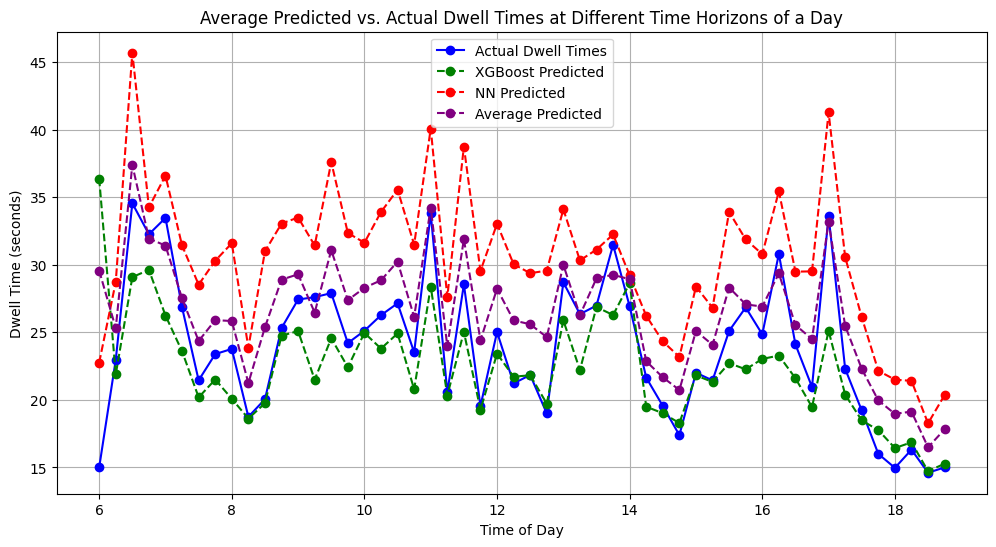

In [112]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named X_test with the provided dataset

# Group the data by time_of_day and calculate the mean for each group
grouped = X_test.groupby('time_of_day').mean()

# Extract the time_of_day and actual running times
time_of_day = grouped.index
actual_dwell_times = grouped['dwell_time_in_seconds']
xgb_pred = grouped['xgbPred']
nn_pred = grouped['NNPred']
avg_pred = grouped['avgPred']

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(time_of_day, actual_dwell_times, label='Actual Dwell Times', marker='o', linestyle='-', color='blue')
plt.plot(time_of_day, xgb_pred, label='XGBoost Predicted', marker='o', linestyle='--', color='green')
plt.plot(time_of_day, nn_pred, label='NN Predicted', marker='o', linestyle='--', color='red')
plt.plot(time_of_day, avg_pred, label='Average Predicted', marker='o', linestyle='--', color='purple')

# Add labels and title
plt.xlabel('Time of Day')
plt.ylabel('Dwell Time (seconds)')
plt.title('Average Predicted vs. Actual Dwell Times at Different Time Horizons of a Day')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [ ]:
X_test.columns

In [113]:
ensemble_X = X_test[['deviceid', 'bus_stop', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'dt(w-1)', 'dt(w-2)', 'dt(w-3)', 'dt(t-1)', 'dt(t-2)', 'dt(n-1)',
       'dt(n-2)', 'dt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'rt(n-1)','xgbPred', 'NNPred', 'avgPred']]
ensemble_y = X_test['dwell_time_in_seconds']

In [114]:
# from sklearn.model_selection import train_test_split
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(ensemble_X, ensemble_y, test_size=0.3, random_state=42)

# # Initialize the XGBoost regressor
# xgb_regressor = XGBRegressor()

# # Train the regressor on the training data
# xgb_regressor.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = xgb_regressor.predict(X_test)

# # Calculate the Mean Absolute Error (MAE) on the test set
# mae = mean_absolute_error(y_test, y_pred)

# # Print the MAE
# print(f"Mean Absolute Error (MAE): {mae}")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ensemble_X, ensemble_y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor()

# Train the regressor on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate the Mean Absolute Error (MAE) on the test set
mae = mean_absolute_error(y_test, y_pred)

# Print the MAE
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 11.735036945048122


In [115]:
X_test['ensemble'] = y_pred
X_test

,deviceid,bus_stop,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,dt(w-1),dt(w-2),...,day,month,temp,precip,windspeed,rt(n-1),xgbPred,NNPred,avgPred,ensemble
4165,279,114,2,9.25,0,0,1,35,16.0,16.0,...,14,9,24.0,0.0,6.5,75.0,16.439020,20.061518,18.250269,15.31
6010,121,111,6,15.25,1,0,0,35,14.0,14.0,...,18,9,28.2,0.0,16.2,121.0,15.493595,19.244408,17.369001,10.64
6189,1358,104,0,9.50,0,0,1,36,1.0,0.0,...,19,9,23.5,0.0,9.0,240.0,2.968031,7.094304,5.031167,1.28
5942,275,113,6,12.50,1,0,0,35,16.0,8.0,...,18,9,27.8,0.0,11.5,123.0,15.001879,24.204060,19.602969,18.64
1245,262,108,6,13.25,1,0,0,33,14.0,14.0,...,4,9,26.9,0.0,11.2,108.0,15.493595,17.877235,16.685415,14.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9036,1358,111,0,17.75,0,0,1,37,8.0,15.0,...,26,9,26.1,0.0,0.1,172.0,7.651581,8.258318,7.954949,9.13
5576,279,111,5,12.50,0,1,0,35,12.0,32.0,...,17,9,28.6,0.0,10.8,132.0,13.579996,19.406519,16.493258,12.59
5860,1143,101,6,9.00,1,0,0,35,36.0,15.0,...,18,9,23.3,0.0,8.3,165.0,33.632957,0.000000,16.816479,15.72
9160,1143,107,1,9.25,0,0,1,37,13.0,15.0,...,27,9,24.1,0.0,7.9,75.0,9.090494,34.472408,21.781451,7.81


In [ ]:
X_test['run_time_in_seconds'] = y_test
X_test

In [117]:
grouped

,deviceid,bus_stop,day_of_week,Sunday/holiday,saturday,weekday/end,week_no,dt(w-1),dt(w-2),dt(w-3),...,day,month,temp,precip,windspeed,rt(n-1),xgbPred,NNPred,avgPred,ensemble
time_of_day,,,,,,,,,,,,,,,,,,,,,
6.25,294.400000,101.700000,1.800000,0.000000,0.000000,1.000000,35.800000,22.500000,20.900000,22.600000,...,19.400000,9.000000,18.710000,0.000000,7.740000,139.396992,23.218060,37.934053,30.576057,36.228000
6.50,298.045455,103.000000,2.318182,0.045455,0.045455,0.909091,35.454545,35.318182,29.272727,33.272727,...,17.500000,9.000000,18.640909,0.000000,7.618182,213.590909,28.300293,46.630971,37.465632,44.890455
6.75,399.487805,105.439024,2.780488,0.097561,0.097561,0.804878,35.000000,34.487805,31.121951,31.243902,...,15.536585,8.975610,18.743902,0.000000,6.873171,224.243902,33.204258,32.476233,32.840244,29.630244
7.00,471.902778,106.194444,2.708333,0.097222,0.111111,0.791667,35.263889,25.888889,30.416667,25.916667,...,16.986111,8.986111,19.269444,0.000000,6.780556,203.694444,27.045971,44.918895,35.982433,43.104861
7.25,582.177778,105.977778,3.011111,0.144444,0.133333,0.744444,34.955556,28.322222,23.955556,26.377778,...,15.044444,8.988889,19.251111,0.000000,7.148889,239.844444,24.848806,28.737559,26.793182,25.648667
7.50,505.169643,107.410714,2.723214,0.062500,0.107143,0.830357,35.098214,20.964286,18.964286,19.107143,...,15.964286,8.982143,19.253571,0.000000,6.887500,183.741071,20.461161,28.334046,24.397603,22.461875
7.75,478.200000,108.368421,3.094737,0.105263,0.147368,0.747368,35.305263,19.463158,19.926316,20.589474,...,17.231579,9.000000,19.171579,0.000000,6.872632,176.842105,20.338682,30.304754,25.321718,23.285474
8.00,458.987013,109.090909,2.909091,0.116883,0.181818,0.714286,35.311688,16.337662,16.571429,17.116883,...,17.090909,9.000000,23.527273,0.083143,2.877922,165.337662,18.461199,29.924230,24.192715,22.317662
8.25,513.685714,108.300000,3.028571,0.142857,0.142857,0.757143,35.442857,15.600000,17.500000,17.628571,...,18.128571,9.000000,23.932857,0.102057,2.707143,175.285714,17.880033,25.520344,21.700189,20.879714


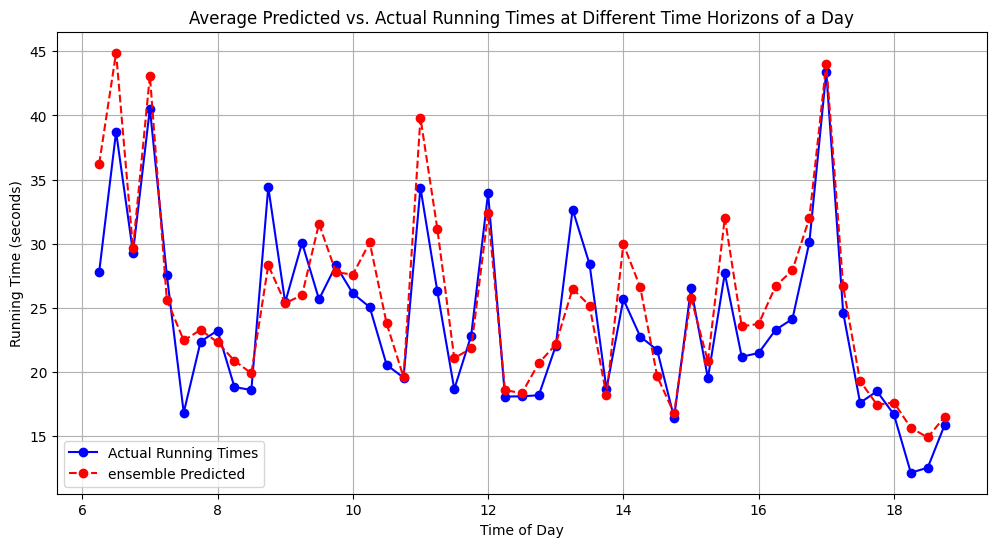

In [119]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named X_test with the provided dataset
X_test = pd.concat([X_test, y_test], axis=1)

# Group the data by time_of_day and calculate the mean for each group
grouped = X_test.groupby('time_of_day').mean()

# Extract the time_of_day and actual running times
time_of_day = grouped.index
actual_dwell_times = grouped['dwell_time_in_seconds']
xgb_pred = grouped['xgbPred']
nn_pred = grouped['NNPred']
avg_pred = grouped['ensemble']

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(time_of_day, actual_dwell_times, label='Actual Running Times', marker='o', linestyle='-', color='blue')
# plt.plot(time_of_day, xgb_pred, label='XGBoost Predicted', marker='o', linestyle='--', color='green')
# plt.plot(time_of_day, nn_pred, label='NN Predicted', marker='o', linestyle='--', color='red')
plt.plot(time_of_day, avg_pred, label='ensemble Predicted', marker='o', linestyle='--', color='red')

# Add labels and title
plt.xlabel('Time of Day')
plt.ylabel('Running Time (seconds)')
plt.title('Average Predicted vs. Actual Running Times at Different Time Horizons of a Day')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()
